This code is based off an example from the DeepXDE documentation.

We attempt to use the DeepXDE library to model the set of coupled differential equations that govern the patterns of Earth’s temperature, Ice coverage, and CO2 based on the data acquired during the last half-century.

The DeepXDE library employs Physics Informed Neural Networks that find the coefficients of ODEs given a dataset that can be modeled by the ODE system.

Documentation: [DeepXDE Example](https://deepxde.readthedocs.io/en/latest/demos/lorenz.inverse.html)

In [ ]:
!pip install deepxde

Imports and functions

In [ ]:
# This code is based off of the DeepXDE Lorenze Inverse example.
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import io
import re

import matplotlib.pyplot as plt
import numpy as np
import requests

import deepxde as dde
from deepxde.backend import tf


In [ ]:
#Extract the data.
import requests
import numpy as np
import pandas as pd

#Download the file to csv. This data comes from the World Meteorological Organization as well as datahub.io.
url = 'https://raw.githubusercontent.com/NolanKoblischke/GoodDynamics/main/ClimateData_AverageTemperature.csv'
r = requests.get(url)
with open('ClimateData_AverageTemperature.csv', 'wb') as f:
    f.write(r.content)

#Read the file into a dataframe
df = pd.read_csv('ClimateData_AverageTemperature.csv', index_col=0)

#Only take Year, Temperature, Sea Ice Coverage, and CO2 (ppm)
df = df[['Year', 'Temperature', 'Sea Ice Coverage', 'CO2 (ppm)']]

#Make the year column start at 0
df['Year'] = df['Year']-1959

#Make t numpy array with the years in shape (1,n)
ob_t = np.array(df['Year']).reshape(len(df['Year']),1)

#Make y numpy array from the rest of the columns
ob_y = np.array(df.drop('Year', axis=1))


In [ ]:
print(df.head())

   Year  Temperature  Sea Ice Coverage   CO2 (ppm)
0     0    14.013539          0.076864  316.280000
1     1    13.947003          0.075551  317.125833
2     2    14.037778          0.074863  317.988333
3     3    13.996948          0.075498  318.646667
4     4    14.023509          0.075833  319.417500


In [ ]:
# parameters to be identified
alpha1= tf.Variable(1.0)
alpha2= tf.Variable(1.0)
epsilon1= tf.Variable(1.0)
epsilon2= tf.Variable(1.0)
beta= tf.Variable(1.0)
a= tf.Variable(1.0)
b= tf.Variable(1.0)
k= tf.Variable(1.0)
m= tf.Variable(1.0)

## The ODE system:
T: Global Mean Temperature

I: Percentage of Sea Ice Coverage

E: CO2 concentration (ppm)

$$
\begin{aligned}
&\frac{d T}{d t}=q(1-(\alpha_1 + \alpha_2 S))-(\epsilon_1+\epsilon_2 E)\sigma_{SB} T^{4}
\\
&\frac{d S}{d t}=\beta-a T \\
&\frac{d E}{d t}=b E+k
\end{aligned}
$$



The temperature differential was modified from: [Climate Modeling in Differential
Equations](https://www2.oberlin.edu/math/faculty/walsh/UMAPclimate.pdf)

The alpha terms represent albedo, which we estimate is a linear function of sea ice.
The epsilon terms represent the greenhouse effect, which we estimate is a linear function of CO2 concentration.

In [ ]:
sigma = 5.670367e-8 #Stefan Boltzmann
q = 342 #annual global mean incoming solar radiation per square meter of the Earth’s surface

# define system ODEs
def Climate_system(t, y):
    """Climate system. Columns T, S, E
    """
    T, S,E = y[:, 0:1], y[:, 1:2], y[:, 2:]
    dT_t = dde.grad.jacobian(y, t, i=0)
    dS_t = dde.grad.jacobian(y, t, i=1)
    dE_t = dde.grad.jacobian(y, t, i=2)

    return [
      dT_t - q*(1-(alpha1+alpha2*S))+(epsilon1+epsilon2*E)*sigma*T**4,
      dS_t - beta+a*T,
      dE_t -b*E-k
    ]

def boundary(_, on_initial):
    return on_initial

In [ ]:
print("Initial Conditions: ", ob_y[0])
print("Date Range:", ob_t[0][0],ob_t[-1][0])

Initial Conditions:  [1.40135392e+01 7.68638220e-02 3.16280000e+02]
Date Range: 0 57


Define data and BCs

In [ ]:
# define time domain
geom = dde.geometry.TimeDomain(ob_t[0][0],ob_t[-1][0])

# Initial conditions
ic1 = dde.IC(geom, lambda X: ob_y[0][0], boundary, component=0)
ic2 = dde.IC(geom, lambda X: ob_y[0][1], boundary, component=1)
ic3 = dde.IC(geom, lambda X: ob_y[0][2], boundary, component=2)

# Get the training data  Columns T, S, E
observe_T = dde.PointSetBC(ob_t, ob_y[:, 0:1], component=0)
observe_S = dde.PointSetBC(ob_t, ob_y[:, 1:2], component=1)
observe_E = dde.PointSetBC(ob_t, ob_y[:, 2:], component=2)


# define data object
data = dde.data.PDE(
    geom,
    Climate_system,
    [ic1, ic2, ic3, observe_T,  observe_S,  observe_E],
    num_domain=400,
    num_boundary=2,
    anchors=ob_t,
)

plt.plot(ob_t, ob_y)
plt.xlabel('Time')
plt.legend(['T','S','E'])
plt.title('Training data')
plt.show()


Train network

In [ ]:
# define FNN architecture and compile
net = dde.maps.FNN([1] + [40] * 3 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)
model.compile("adam", lr=0.001)

# callbacks for storing results
fnamevar = "variables.dat"
variable = dde.callbacks.VariableValue(    
    [alpha1, alpha2, epsilon1, epsilon2, beta, a, b, k], 
    period=1,
    filename=fnamevar
)


losshistory, train_state = model.train(epochs=150000, callbacks=[variable])

 Plot identified parameters

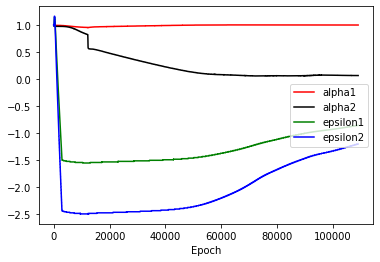

In [ ]:
# reopen saved data using callbacks in fnamevar 
lines = open(fnamevar, "r").readlines()

# read output data in fnamevar
Chat = np.array([np.fromstring(min(re.findall(re.escape('[')+"(.*?)"+re.escape(']'),line), key=len), sep=',') for line in lines])

l,c = Chat.shape
plt.plot(range(l),Chat[:,0],'r-')
plt.plot(range(l),Chat[:,1],'k-')
plt.plot(range(l),Chat[:,2],'g-')
plt.plot(range(l),Chat[:,3],'b-')

plt.legend(['alpha1', 'alpha2', 'epsilon1', 'epsilon2'],loc = "right")
plt.xlabel('Epoch')
plt.show()

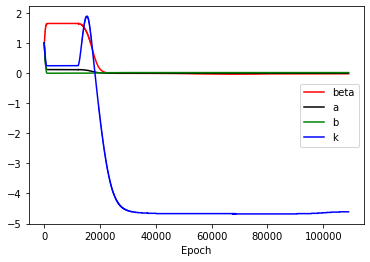

In [ ]:
plt.plot(range(l),Chat[:,4],'r-')
plt.plot(range(l),Chat[:,5],'k-')
plt.plot(range(l),Chat[:,6],'g-')
plt.plot(range(l),Chat[:,7],'b-')


plt.legend(['beta', 'a', 'b', 'k'],loc = "right")
plt.xlabel('Epoch')
plt.show()

In [ ]:
#Printing the final values of the parameters
param_list = ['alpha1', 'alpha2', 'epsilon1', 'epsilon2', 'beta', 'a', 'b', 'k']

for i, val in enumerate(param_list):
  print(val, ":", Chat[-1,i])

alpha1 : 0.998
alpha2 : 0.0652
epsilon1 : -0.855
epsilon2 : -1.2
beta : -0.0218
a : -0.0015
b : 0.0174
k : -4.61


In [ ]:
yhat = model.predict(ob_t)

plt.plot(ob_t, ob_y,'-',ob_t, yhat,'--')
plt.xlabel('Time')
plt.legend(['T','S','E','Th','Sh','Eh'])
plt.title('Training data')
plt.show()

In [ ]:
#Plotting the known data and the modeled data on seperate plots

df_yhat = pd.DataFrame(yhat, columns=df.columns[1:])
df_yhat.columns = [col+"_predicted" for col in df_yhat.columns]
for i in range(0,len(df_yhat.columns)):
  df_yhat.iloc[:,i].plot()
  df.iloc[:,i+1].plot()
  plt.legend(loc='best')
  plt.title(df_yhat.columns[i])
  plt.show()

Results of our best run are on the github page.